In [187]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf

In [188]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [189]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.

# YOUR CODE BELOW

df = pd.read_csv("Contributors/sample15.csv")

assert len(df.columns) == 2
assert df.columns[0] == "contributor"
assert df.columns[1] == "bothunter_type"

print(df)



                      contributor bothunter_type
0                         BwL1289          Human
1                 DilumAluthgeBot          Human
2                        HelenaLC          Human
3                JuliaRegistrator            Bot
4                        Micky774          Human
5                    ShixiangWang          Human
6                        ZedThree          Human
7            allcontributors[bot]            Bot
8                   andrewfullard          Human
9                     b-rodrigues          Human
10                 bioc-issue-bot            Bot
11                  brosaplanella          Human
12                     chainer-ci            Bot
13                   codecov[bot]            Bot
14                       commit-0          Human
15                      coveralls            Bot
16                      cwhite911          Human
17                        dzenanz          Human
18                   editorialbot          Human
19                  

In [190]:
# 1. Store the names of the contributors in a list
# 2. print the list

# YOUR CODE BELOW

contributors = df["contributor"]

print(contributors)

0                           BwL1289
1                   DilumAluthgeBot
2                          HelenaLC
3                  JuliaRegistrator
4                          Micky774
5                      ShixiangWang
6                          ZedThree
7              allcontributors[bot]
8                     andrewfullard
9                       b-rodrigues
10                   bioc-issue-bot
11                    brosaplanella
12                       chainer-ci
13                     codecov[bot]
14                         commit-0
15                        coveralls
16                        cwhite911
17                          dzenanz
18                     editorialbot
19                           fubar2
20              github-actions[bot]
21    github-advanced-security[bot]
22                         hmaarrfk
23                      imagesc-bot
24                          jbednar
25               jorisvandenbossche
26                       kellertuer
27                     longe

In [191]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

# YOUR CODE BELOW
app_dict = []

for contributor in contributors:
    query = f'{QUERY_ROOT}/users/{contributor}'
    response = requests.get(query, headers = HEADERS)
    if response.status_code == 200:
        json_response = response.json()
        is_bot = json_response.get('type') == "Bot"
        app_dict.append({'contributor': contributor, 'app': is_bot})
    else:
        print(f"Error fetching data for {contributor}: {response.status_code}")

app_df = pd.DataFrame.from_dict(app_dict)
        
print(app_df)

Error fetching data for BwL1289: 401
Error fetching data for DilumAluthgeBot: 401
Error fetching data for HelenaLC: 401
Error fetching data for JuliaRegistrator: 401
Error fetching data for Micky774: 401
Error fetching data for ShixiangWang: 401
Error fetching data for ZedThree: 401
Error fetching data for allcontributors[bot]: 401
Error fetching data for andrewfullard: 401
Error fetching data for b-rodrigues: 401
Error fetching data for bioc-issue-bot: 401
Error fetching data for brosaplanella: 401
Error fetching data for chainer-ci: 401
Error fetching data for codecov[bot]: 401
Error fetching data for commit-0: 401
Error fetching data for coveralls: 401
Error fetching data for cwhite911: 401
Error fetching data for dzenanz: 401
Error fetching data for editorialbot: 401
Error fetching data for fubar2: 401
Error fetching data for github-actions[bot]: 401
Error fetching data for github-advanced-security[bot]: 401
Error fetching data for hmaarrfk: 401
Error fetching data for imagesc-bot:

### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [192]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

# YOUR CODE BELOW
app_df = app_df.rename(columns={"app": "user_type"})

merged_df = pd.merge(df, app_df, on='contributor')
merged_df

KeyError: 'contributor'

### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [ ]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

# YOUR CODE BELOW

da = pd.read_csv("all_events.csv")

da['created_at'] = pd.to_datetime(da['created_at'], unit='ms')
filtered_events = da.query("login in @contributors")

filtered_events


,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
3,3,39747379822,IssueCommentEvent,codecov[bot],napari/napari,2024-07-01 00:00:10,created,7043.0,open,PR_kwDOCJ0aI85z_6lX,...,IC_kwDOCJ0aI86DDzXh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
6,6,39747396929,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:01:47,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKwX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
15,15,39747413489,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:03:24,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKw0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
16,16,39747416135,PushEvent,github-actions[bot],napari/npe2api,2024-07-01 00:03:40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
21,21,39747427332,CreateEvent,github-actions[bot],SciML/PubChem.jl,2024-07-01 00:04:44,NaN,NaN,NaN,NaN,...,NaN,NaN,compathelper/new_version/2024-07-01-00-04-42-9...,branch,NaN,NaN,NaN,NaN,NaN,SciML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358391,358391,42415303969,PushEvent,github-actions[bot],SciML/LineSearch.jl,2024-09-30 23:24:21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
358398,358398,42415372311,IssueCommentEvent,codecov[bot],pybamm-team/PyBaMM,2024-09-30 23:28:49,created,4477.0,closed,PR_kwDOCUVVSc59LeQ9,...,IC_kwDOCUVVSc6OH0Z2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pybamm-team
358401,358401,42415474205,PushEvent,github-actions[bot],Bioconductor/gha-build-jupyter-release-amd64,2024-09-30 23:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bioconductor
358403,358403,42415512378,PushEvent,github-actions[bot],napari/npe2api,2024-09-30 23:37:12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari


### Execute BIMBAS to obtain the predictions

In [ ]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [ ]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

# YOUR CODE BELOW
bimbas_df = execute_bimbas(contributors, filtered_events)
bimbas_df

100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


,contributor,bimbas_type,confidence
0,BwL1289,Human,0.810
1,DilumAluthgeBot,Bot,0.894
2,HelenaLC,Bot,0.740
3,JuliaRegistrator,Bot,0.886
4,Micky774,Human,0.884
5,ShixiangWang,Human,0.801
6,ZedThree,Human,0.821
7,allcontributors[bot],Bot,0.567
8,andrewfullard,Human,0.459
9,b-rodrigues,Human,0.850


### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [ ]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.
merged_bimbas_df = pd.merge(merged_df, bimbas_df, on='contributor')
merged_bimbas_df

,contributor,bothunter_type,user_type,bimbas_type,confidence
0,BwL1289,Human,False,Human,0.810
1,DilumAluthgeBot,Human,False,Bot,0.894
2,HelenaLC,Human,False,Bot,0.740
3,JuliaRegistrator,Bot,False,Bot,0.886
4,Micky774,Human,False,Human,0.884
5,ShixiangWang,Human,False,Human,0.801
6,ZedThree,Human,False,Human,0.821
7,allcontributors[bot],Bot,True,Bot,0.567
8,andrewfullard,Human,False,Human,0.459
9,b-rodrigues,Human,False,Human,0.850


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [ ]:
# Hint: use the cohen_kappa_score library
# YOUR CODE BELOW
cohen = cohen_kappa_score(y1= merged_bimbas_df['bothunter_type'], y2= merged_bimbas_df['bimbas_type'])
cohen

np.float64(0.6111111111111112)

### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [ ]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

# YOUR CODE BELOW

manual_list_dict = [
    {'contributor': 'DilumAluthgeBot', 'manual': 'Bot'}, # The pull request are automatic with similarly commits
    {'contributor': 'mergify[bot]', 'manual': 'Bot'}, #user_type is true
    {'contributor': 'HelenaLC', 'manual': 'Human'}, #She lives in Spain, her name is likely as human name convention
    {'contributor': 'commit-0', 'manual': 'Bot'}, #No profile define, seem like an organization
    {'contributor': 'editorialbot', 'manual' : 'Bot'}, #6,221 contributions in the last year
    {'contributor': 'imagesc-bot', 'manual': 'Bot'}, #No contribution in 5 years but the name let us presumes it's a bot
    {'contributor': 'nglm', 'manual': 'Human'}, #her name is Natacha Galmiche and she is a researcher in machine learning
    ] 


In [193]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.

merged_bimbas_df.loc[
    (merged_bimbas_df['user_type'] == True) | ((merged_bimbas_df['bimbas_type'] == 'Bot') & (merged_bimbas_df['bothunter_type'] == 'Bot')),
    'acc_type'
] = 'Bot'

merged_bimbas_df.loc[
    (merged_bimbas_df['bimbas_type'] == 'Human') & (merged_bimbas_df['bothunter_type'] == 'Human'),
    'acc_type'
] = 'Human'

manual_df = pd.DataFrame(manual_list_dict)
merged_bimbas_df = merged_bimbas_df.merge(manual_df, on='contributor', how='left')

merged_bimbas_df['acc_type'] = merged_bimbas_df['manual'].fillna(merged_bimbas_df['acc_type'])
merged_bimbas_df = merged_bimbas_df.drop(columns=['manual'])

merged_bimbas_df


,contributor,bothunter_type,user_type,bimbas_type,confidence,acc_type
0,BwL1289,Human,False,Human,0.810,Human
1,DilumAluthgeBot,Human,False,Bot,0.894,Bot
2,HelenaLC,Human,False,Bot,0.740,Human
3,JuliaRegistrator,Bot,False,Bot,0.886,Bot
4,Micky774,Human,False,Human,0.884,Human
5,ShixiangWang,Human,False,Human,0.801,Human
6,ZedThree,Human,False,Human,0.821,Human
7,allcontributors[bot],Bot,True,Bot,0.567,Bot
8,andrewfullard,Human,False,Human,0.459,Human
9,b-rodrigues,Human,False,Human,0.850,Human


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

In [ ]:
# 1 - 'DilumAluthgeBot' Bump the stdlib packages from c54ee594d to 60e3185e3 in every pull request
# 2 - 'commit-0' Automate contributions in GitHub repositories.
# 3 - 'editorialbot' Merging pull request weekly
# 4 - 'editorialbot' Updating files usually
# 5 - 'mergify[bot]' Usually merge pull request 

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [194]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']






In [195]:
# YOUR CODE BELOW
# Function to assign event group
def assign_event_group(event_type):
    if event_type in issue_group:
        return 'Issue-Related'
    elif event_type in pr_group:
        return 'PR-Related'
    elif event_type in commit_group:
        return 'Commit-Related'
    elif event_type in repo_group:
        return 'Repository-Management'
    else:
        return 'Other'

In [197]:
# YOUR CODE BELOW

# Apply function to create new column
filtered_events['event_group'] = filtered_events['event_type'].apply(assign_event_group)

# Group by 'login' and 'event_group', then count occurrences
event_counts = (
    filtered_events
    .groupby(['login', 'event_group'])
    .agg(event_count=('event_id', 'count'))  # Counting number of events per group
    .reset_index()  # Reset index for better readability
)

# Pivot the table
event_pivot = event_counts.pivot(index='login', columns='event_group', values='event_count')

# Reset index and rename axis
event_pivot = event_pivot.reset_index().rename_axis(None, axis=1)

# Rename event groups to match required column names
event_pivot = event_pivot.rename(columns={
    'PR-Related': 'PR',
    'Issue-Related': 'issue',
    'Repository-Management': 'repo',
    'Commit-Related': 'commit'
})

# Select only required columns, filling missing event counts with 0
final_df = (
    merged_bimbas_df[['contributor', 'acc_type']]
    .merge(event_pivot[['login', 'PR', 'issue', 'commit', 'repo']], left_on='contributor', right_on='login', how='left')
    .drop(columns=['contributor'])  # Drop unnecessary columns
    .fillna(0)  # Replace NaN with 0
)


# Display result
display(final_df)

C:\Users\tdjou\AppData\Local\Temp\ipykernel_23616\3217706188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['event_group'] = filtered_events['event_type'].apply(assign_event_group)


,acc_type,login,PR,issue,commit,repo
0,Human,BwL1289,1.0,15.0,0.0,0.0
1,Bot,DilumAluthgeBot,24.0,0.0,0.0,0.0
2,Human,HelenaLC,0.0,11.0,0.0,0.0
3,Bot,JuliaRegistrator,0.0,364.0,82.0,0.0
4,Human,Micky774,6.0,15.0,1.0,0.0
5,Human,ShixiangWang,1.0,11.0,2.0,0.0
6,Human,ZedThree,9.0,5.0,0.0,0.0
7,Bot,allcontributors[bot],10.0,10.0,23.0,10.0
8,Human,andrewfullard,247.0,119.0,112.0,27.0
9,Human,b-rodrigues,36.0,70.0,114.0,21.0


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [15]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [203]:
# YOUR CODE BELOW
bot_actors_df = final_df[final_df['acc_type'] == 'Bot']
human_df = final_df[final_df['acc_type'] == 'Human']

# Compute median event count for each event group (PR, issue, repo) for Bots and Humans
bot_medians = bot_actors_df[['PR', 'issue', 'repo', 'commit']].median().reset_index()
human_medians = human_df[['PR', 'issue', 'repo', 'commit']].median().reset_index()

# Assign correct labels
bot_medians.columns = ['event_group', 'median']
bot_medians['acc_type'] = 'Bot_app'

human_medians.columns = ['event_group', 'median']
human_medians['acc_type'] = 'Human'

# Combine the two DataFrames into one
df_medians = pd.concat([bot_medians, human_medians], ignore_index=True)


display(df_medians)

,event_group,median,acc_type
0,PR,0.0,Bot_app
1,issue,115.0,Bot_app
2,repo,0.0,Bot_app
3,commit,0.0,Bot_app
4,PR,13.0,Human
5,issue,21.0,Human
6,repo,3.0,Human
7,commit,1.0,Human


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [17]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot
1,event_group1,val2,Human
2,event_group2,val3,Bot
3,event_group2,val4,Human
4,event_group3,val5,Bot
5,event_group3,val6,Human
6,event_group4,val7,Bot
7,event_group5,val8,Human


In [204]:
# pivot the main DataFrame
df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)

event_group,PR,commit,issue,repo
acc_type,,,,
Bot_app,0.0,0.0,115.0,0.0
Human,13.0,1.0,21.0,3.0


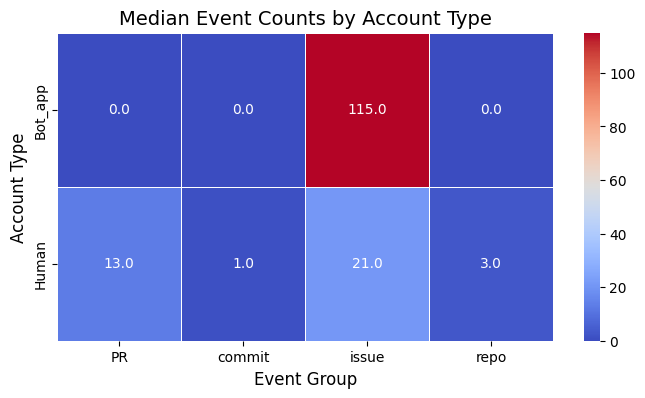

In [205]:
# YOUR CODE BELOW
# Pivot the DataFrame so that 'acc_type' becomes the index and 'event_group' the columns
heatmap_data = df_medians.pivot(index='acc_type', columns='event_group', values='median')

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".1f", linewidths=0.5)

plt.title("Median Event Counts by Account Type", fontsize=14)
plt.xlabel("Event Group", fontsize=12)
plt.ylabel("Account Type", fontsize=12)

plt.show()

In [26]:
# YOUR CODE BELOW


#### What is the difference that you observe between Bots+Bot actors and Humans?

In [ ]:
#Bots+Bot .contribute more to issues events

#### What is the differnce that you observe between Event groups?

In [ ]:
#The median value in issue event group is the most significant over the three

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

In [ ]:
#Bots play a critical role in managing issues and they are not involved in commit, code review or repository management.
#while humans are more involved in PRS, issue discussions

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

In [27]:
# YOUR CODE BELOW - Visualize number of events from pull request event group


In [28]:
# YOUR CODE BELOW - Visualise number of events from issue event group


In [29]:
# YOUR CODE BELOW - Visualise number of events from commit event group


In [30]:
# YOUR CODE BELOW - Visualise number of events from repo event group


### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [ ]:
# YOUR CODE BELOW

### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [31]:
# YOUR CODE BELOW

### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [ ]:
# YOU CODE BELOW